In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np

Load the data from .wav and .xlsx files

In [2]:
# Define the root folder containing all subfolders
root_folder = "task1/training"

# Prepare a list to store data
data = []

# Walk through all subfolders and files
for subdir, _, files in os.walk(root_folder):
    for file in files:
        if file.endswith('.wav'):
            filepath = os.path.join(subdir, file)
            sample_rate, audio = wavfile.read(filepath)
            # Store subfolder name for reference
            subfolder = os.path.basename(subdir)
            data.append({
                'filename': file,
                'patient_id': file.split('_')[0],
                'exercise': subfolder,
                'sample_rate': sample_rate,
                'audio': audio
            })

# Create a DataFrame
df = pd.DataFrame(data)

# Show the first few rows
df.head()

,filename,patient_id,exercise,sample_rate,audio
0,ID000_phonationA.wav,ID000,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ID001_phonationA.wav,ID001,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ID002_phonationA.wav,ID002,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ID003_phonationA.wav,ID003,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ID005_phonationA.wav,ID005,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
# Load the Excel file with patient info
excel_path = "task1/sand_task_1.xlsx"
patient_info = pd.read_excel(excel_path, usecols=["ID", "Age", "Sex", "Class"], engine="openpyxl")

# Merge patient info into your main DataFrame
df = df.merge(patient_info, left_on="patient_id", right_on="ID", how="left")

# Drop the redundant 'ID' column if desired
df = df.drop(columns=["ID"])

# Show the updated DataFrame
df.head()

,filename,patient_id,exercise,sample_rate,audio,Age,Sex,Class
0,ID000_phonationA.wav,ID000,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",80,M,5
1,ID001_phonationA.wav,ID001,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",61,F,5
2,ID002_phonationA.wav,ID002,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",51,F,4
3,ID003_phonationA.wav,ID003,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",59,M,3
4,ID005_phonationA.wav,ID005,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",80,F,5


Define functions for getting the data from the df

In [4]:
from typing import Tuple, List

max_time = 15 # Mazimum time to read in exercises, s
fs = df['sample_rate'].iloc[0]
exercise_list = []
for ex in df['exercise'].unique():
    if 'rhythm' in ex.lower():  # Select only rhythm exercises
        exercise_list.append(ex)

def load_data(df: pd.DataFrame, fs=fs, max_time=max_time, exercise_list=exercise_list) -> Tuple[np.ndarray, List[str], np.ndarray]:
    df_rhythm = df[df['exercise'].isin(exercise_list)].reset_index(drop=True)
    patient_ids = df_rhythm['patient_id'].unique()  # preserves first-seen order
    n_pz = len(patient_ids)
    n_ex = len(exercise_list)
    max_t = int(max_time * fs)

    data_matrix = np.zeros((n_pz, n_ex, max_t))
    patient_id_to_index = {pid: idx for idx, pid in enumerate(patient_ids)}
    exercise_to_index = {ex: idx for idx, ex in enumerate(exercise_list)}

    for _, row in df_rhythm.iterrows():
        pid_idx = patient_id_to_index[row['patient_id']]
        ex_idx = exercise_to_index[row['exercise']]
        audio = np.array(row['audio'])
        end = min(len(audio), max_t)
        data_matrix[pid_idx, ex_idx, :end] = audio[:end]

    sex_list = [df.loc[df['patient_id'] == pid, 'Sex'].iloc[0] for pid in patient_ids]

    return data_matrix, sex_list, patient_ids



Define the preprocessing functions

In [5]:
import numpy as np
from scipy.signal import butter, lfilter
from scipy.interpolate import interp1d
from tensorflow.keras.models import load_model
import joblib

# ====== Settings ======
max_time = 15
fs = df['sample_rate'].iloc[0]
cutoff = 2000
f_max = 2000
order = 4
reducing_time_factor = 0.6
augmentation_factor = 10
smooth_dim = 200
smooth_kind = 'quadratic'
smooth_fill_value = "extrapolate"
n_cl = 5

# ====== Load models ======
NN_binary_M = load_model('models/NN_rhythm_binary_M.keras')
NN_binary_F = load_model('models/NN_rhythm_binary_F.keras')
NN_categorical_M = load_model('models/NN_rhythm_categorical_1_4_M.keras')
NN_categorical_F = load_model('models/NN_rhythm_categorical_1_4_F.keras')

# Load scalers
scaler_M = joblib.load("models/XM_rhythm_scaler.pkl")
scaler_F = joblib.load("models/XF_rhythm_scaler.pkl")

# ====== Helper functions ======
def butter_lowpass_filter(signal, cutoff=cutoff, fs=fs, order=order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, signal)

def window_slice(x, reduce_ratio=0.5):
    target_len = int(reduce_ratio * x.shape[-1])
    if target_len >= x.shape[-1]:
        return x
    start = np.random.randint(0, x.shape[-1] - target_len)
    return x[..., start:start+target_len]

def preprocess_single_signal(signal):
    """Preprocess one 1D signal: augment, filter, FFT, interpolate."""
    # Convert to float32
    signal = signal.astype(np.float32)
    
    augmented_chunks = []
    for _ in range(augmentation_factor):
        sliced = window_slice(signal, reducing_time_factor)
        filtered = butter_lowpass_filter(sliced)
        fft_vals = np.fft.rfft(filtered)
        freqs = np.fft.rfftfreq(len(filtered), d=1/fs)
        mask = freqs <= f_max
        fft_vals = np.abs(fft_vals[mask])
        f = interp1d(freqs[mask], fft_vals, kind=smooth_kind, fill_value=smooth_fill_value)
        interpolated = f(np.linspace(0, f_max, smooth_dim))
        augmented_chunks.append(interpolated)
    
    return np.stack(augmented_chunks, axis=0)  # shape -> (augmentation_factor, smooth_dim)

def preprocess_data(signals):
    """Process all patients in a memory-efficient way."""
    n_patients, n_ex, t_len = signals.shape
    # Preallocate final array
    X_processed = np.empty((n_patients, augmentation_factor, n_ex, smooth_dim), dtype=np.float32)
    
    for i in range(n_patients):
        for j in range(n_ex):
            X_processed[i, :, j, :] = preprocess_single_signal(signals[i, j])
    
    return X_processed


Define the actual classifier

In [6]:
import tensorflow as tf
from scipy.stats import mode

def mixed_model(X: np.ndarray, sex_list: list[str], n_cl=n_cl) -> np.ndarray:
    """
    Predict categorical distribution for patients with mixed sexes.
    Uses direct model calls (not .predict) to avoid retracing.
    """
    n_patients = X.shape[0]
    out = np.zeros((n_patients, n_cl), dtype=np.float32)
    sex_array = np.array(sex_list)

    # Convert once to tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)

    # ---- Process males ----
    idx_M = np.where(sex_array == 'M')[0]
    if len(idx_M) > 0:
        X_M = tf.gather(X_tensor, idx_M)
        healthy_pred_M = NN_binary_M(X_M, training=False).numpy()
        is_healthy_M = np.argmax(healthy_pred_M, axis=1) == 1

        out[idx_M[is_healthy_M], -1] = 1
        if np.any(~is_healthy_M):
            cat_pred_M = NN_categorical_M(tf.gather(X_M, np.where(~is_healthy_M)[0]), training=False).numpy()
            out[idx_M[~is_healthy_M], :n_cl - 1] = cat_pred_M

    # ---- Process females ----
    idx_F = np.where(sex_array == 'F')[0]
    if len(idx_F) > 0:
        X_F = tf.gather(X_tensor, idx_F)
        healthy_pred_F = NN_binary_F(X_F, training=False).numpy()
        is_healthy_F = np.argmax(healthy_pred_F, axis=1) == 1

        out[idx_F[is_healthy_F], -1] = 1
        if np.any(~is_healthy_F):
            cat_pred_F = NN_categorical_F(tf.gather(X_F, np.where(~is_healthy_F)[0]), training=False).numpy()
            out[idx_F[~is_healthy_F], :n_cl - 1] = cat_pred_F

    return out


def classify_data(signals, sex_list):
    """Classify patient signals with minimal memory usage + sex-specific scaling."""
    X_processed = preprocess_data(signals)  
    n_patients, n_chunks, n_ex, n_features = X_processed.shape

    # Flatten into (n_samples * n_chunks * n_ex, n_features)
    flat_X = X_processed.reshape(-1, n_features)
    expanded_sex = np.repeat(sex_list, n_chunks * n_ex)

    # ---- Apply scaling separately for M and F ----
    X_scaled = np.zeros_like(flat_X, dtype=np.float32)

    idx_M = np.where(expanded_sex == "M")[0]
    if len(idx_M) > 0:
        X_scaled[idx_M] = scaler_M.transform(flat_X[idx_M])

    idx_F = np.where(expanded_sex == "F")[0]
    if len(idx_F) > 0:
        X_scaled[idx_F] = scaler_F.transform(flat_X[idx_F])

    # ---- Model prediction ----
    predictions = mixed_model(X_scaled, expanded_sex)
    predictions = predictions.reshape(n_patients, n_chunks, n_ex, n_cl)

    # Convert to class predictions
    pred_classes = np.argmax(predictions, axis=-1)   # shape: (n_patients, n_chunks, n_ex)

    # Collapse chunks and exercises, then take the mode
    modas = mode(pred_classes.reshape(n_patients, -1), axis=1)

    # Return the most frequent class per patient
    return modas.mode.squeeze()

Classify Actual data

F1 score: 0.7850745808918482


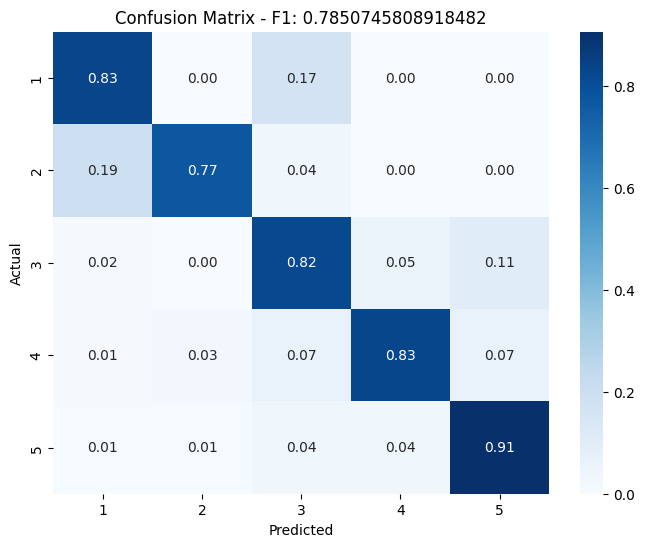

In [8]:
# For now select only a subset of data
ids = df['patient_id'].unique()
n = ids.shape[0]
# n = 10
ids_trim = ids[:n]
df_trim = df[df['patient_id'].isin(ids_trim)]


signals, sex_list, patient_ids = load_data(df_trim)

# Align y_true with the patient order
y_true = (
    df_trim.groupby('patient_id')['Class']
    .unique()
    .map(lambda x: x[0])
    .reindex(patient_ids)  # reorder to match signals
    .to_numpy()
    .astype(int) - 1
)
y_pred = classify_data(signals, sex_list)

from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - F1: {f1}')
plt.show()

Now do it only on not seen patients

F1 score: 0.2089612403100775


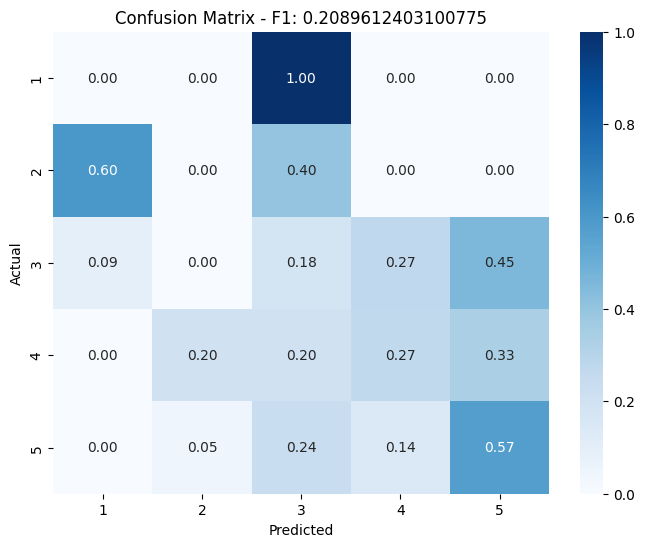

In [9]:
with open("excluded_patient_ids.txt", "r") as file:
    excluded_ids = [line.strip() for line in file]

df_excl = df[df['patient_id'].isin(excluded_ids)]

df_rhythm = df_excl[df_excl['exercise'].isin(exercise_list)].reset_index(drop=True)
patient_ids = df_rhythm['patient_id'].unique()  # preserves first-seen order

signals, sex_list, patient_ids = load_data(df_excl)

# Align y_true with the patient order
y_true = (
    df_excl.groupby('patient_id')['Class']
    .unique()
    .map(lambda x: x[0])
    .reindex(patient_ids)  # reorder to match signals
    .to_numpy()
    .astype(int) - 1
)
y_pred = classify_data(signals, sex_list)


from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - F1: {f1}')
plt.show()